## code

In [67]:
import pandas as pd
import numpy as np
import hvplot.pandas  # noqa
import matplotlib.pyplot as plt
import logging
import copy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# import lab_tools
import pickle
logging.basicConfig(level=logging.INFO)
import math
from scipy.constants import mu_0 as mu_0
from uncertainties import ufloat
import uncertainties
from uncertainties.umath import * 
from uncertainties import unumpy
from matplotlib import pyplot
import os
from collections import OrderedDict

def uplot(x_ufloats, y_ufloats, ax=plt, **kwargs):
    getattr(ax, 'errorbar')
    plt.errorbar( unumpy.nominal_values(x_ufloats), unumpy.nominal_values(y_ufloats),
      xerr=unumpy.std_devs(x_ufloats), yerr= unumpy.std_devs(y_ufloats),ecolor='green',barsabove=True, **kwargs )


def load_pickle(name):
    with open(os.path.join('pickles',f'{name}.pickle'), 'rb') as handle:
        return pickle.load(handle)

def save_pickle(name, pick):
    if not os.path.exists('pickles'):
        os.makedirs('pickles')
    with open(os.path.join('pickles',f'{name}.pickle'), 'wb') as handle:
        return pickle.dump(pick,handle)

def load_state(state = 'state'):
    globals().update(load_pickle(state))

def save_state():
    data = {k:v for k,v in globals().items() if not k.startswith('_')}
    print(data)
    save_pickle('state', {k:v for k,v in globals().items() if not k.startswith('_')})

def malus_fit(x, a, b):
    return a * np.cos(x - b)**2

def clean_errors(df):
    return df.applymap(unumpy.nominal_values)

def to_matlab(df, name):
    df.applymap(unumpy.nominal_values).to_csv(f'{name}.csv', index=False)


def genrate_fit_data(df, col, addition=10):
    max = unumpy.nominal_values(df[col].max())
    min = unumpy.nominal_values(df[col].min())
    return np.linspace(min - addition, max + addition, 100)

    
def read_to_dict(folder):
    csv_files = os.listdir(folder)
    data_dict = {}
    for x in csv_files:
        path = os.path.join(folder, x)
        try:
            data_dict[os.path.splitext(os.path.basename(path))[0]] = load_data(path)
        except:
            print(f"Error reading file {path}")

    return data_dict

def load_data(path):
    df = pd.read_excel(path, header=None, names=['t', 'p'], skiprows=6)
    return df

def drop(df, col, n):
    largest = df.nlargest(n, col).index.to_list()
    smallest = df.nsmallest(n, col).index.to_list()
    indexces = largest + smallest
    return df.drop(indexces)

def get_min_max_error(df, col):
    max = df[col].max()
    min = df[col].min()
    return (max - min)

def puplot(x_ufloats, y_ufloats, **kwargs):

    # del fig
    
    df_ = pd.DataFrame({
        'x': unumpy.nominal_values(x_ufloats),
        'y': unumpy.nominal_values(y_ufloats),
        'x_err': unumpy.std_devs(x_ufloats),
        'y_err': unumpy.std_devs(y_ufloats)
        })
    
    fig = px.scatter(df_, x="x", y="y",
                 error_x="x_err", error_y="y_err")
    fig.show()
    # return fig

def rad2deg(v):
    return v * 180 / np.pi

def deg2rad(v):
    return v * np.pi / 180

## 2 ploeraizers

In [64]:
# load_state('2_polarizers')
df = pd.read_csv('2_poleraizers.csv')
noise = ufloat(0.23, 0.005) * 1e-3
df = clean_errors(df)
power = []
for i in df['power']:
    power.append(ufloat(i, 0.05 * i) - noise) 
power = np.array(power)
df['power'] = power

angle = []
for i in df['angle']:
    angle.append(ufloat(i, 1/3 * np.pi / 180))
angle = np.array(angle)
# df['angle'] = angle * np.pi / 180

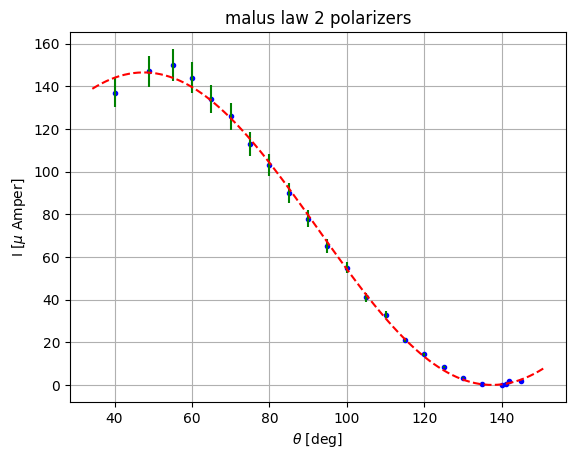

In [72]:

def malus_fit(x, a, b):
    return a * np.cos(x - b)**2

a = 146.48
b = 0.829046

# a = ufloat(146.48, 1.24058)
# b = ufloat(0.829046, 0.00776791)

X = genrate_fit_data(df, 'angle', 0.1)

fig, ax = plt.subplots()
plot_data = uplot(df['angle'] * 180 / np.pi, df['power'], ax=ax, color='b', fmt='.')

pyplot.xlabel(r'$\theta$' + ' [deg]')
pyplot.ylabel('I [$\mu$ Amper]')
pyplot.title('malus law 2 polarizers') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(X * 180 / np.pi, malus_fit(X, a, b), 'r--')

plt.savefig('images/1_malus_2_polerizers.svg', format='svg')
save_pickle('1_malus_2_polarizers', df)


## 3 polerizers

In [73]:
# load_state('2_polarizers')
df = pd.read_csv('3_poleraizers.csv')
df = clean_errors(df)
power = []
for i in df['power']:
    power.append(ufloat(i, 0.05 * i)) 
power = np.array(power)
df['power'] = power

angle = []
for i in df['angle']:
    angle.append(ufloat(i, 1/3 * np.pi / 180))
angle = np.array(angle)

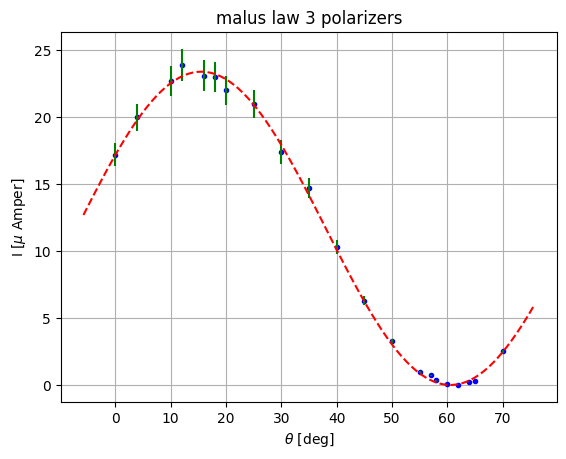

In [78]:
a = ufloat(23.3953, 0.137064)
b = ufloat(0.542803, 0.00647166)

a = 23.3953
b = 0.542803

def malus_fit_3_polar(x, a, b):
    return a * np.cos(2*x - b)**2

X = genrate_fit_data(df, 'angle', 0.1)

fig, ax = plt.subplots()
plot_data = uplot(rad2deg(df['angle']), df['power'], ax=ax, color='b', fmt='.')

pyplot.xlabel(r'$\theta$' + ' [deg]')
pyplot.ylabel('I [$\mu$ Amper]')
pyplot.title('malus law 3 polarizers') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(rad2deg(X), malus_fit_3_polar(X, a, b), 'r--')


plt.savefig('images/2_malus_3_polerizers.svg', format='svg')
save_pickle('3_polarizers', df)


## $\frac{\lambda}{2}$ waveplate

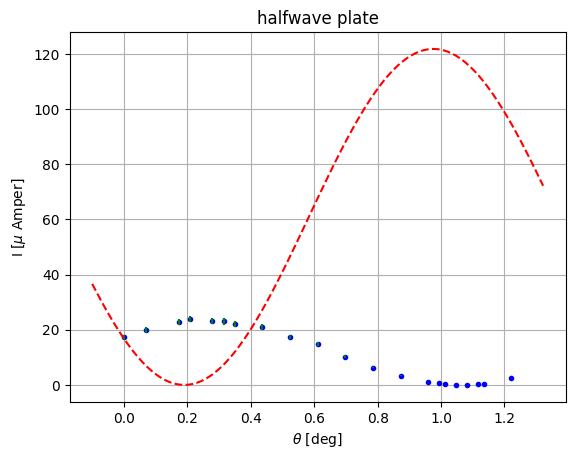

In [80]:
X = genrate_fit_data(df, 'angle', 0.1)

def halfwave_plate(x,a,b):
    return a * np.sin(2*x - b)**2
    
fig, ax = plt.subplots()
plot_data = uplot(df['angle'], df['power'], ax=ax, color='b', fmt='.')


a = ufloat(0.000121804, 8.56308e-07) * 10e5
b = ufloat(0.380604, 0.00750376)


a = 0.000121804 * 10e5
b = 0.380604

pyplot.xlabel(r'$\theta$' + ' [deg]')
pyplot.ylabel('I [$\mu$ Amper]')
pyplot.title('halfwave plate') 
plt.grid()
plot_fit, = ax.plot(X, halfwave_plate(X, a, b), 'r--')


plt.savefig('images/3_halfwave_plate.svg', format='svg')
save_pickle('half_wave', df)

## circle $\frac{\lambda}{4}$

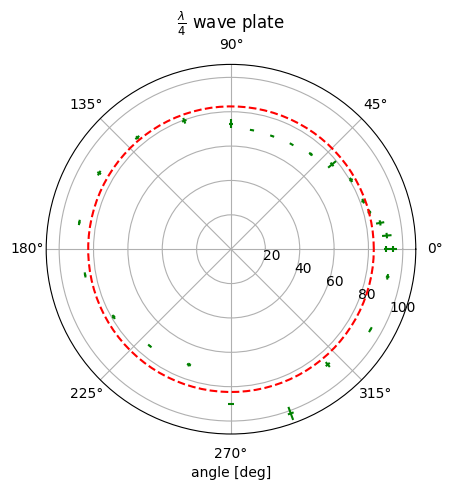

In [90]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# fig, ax = plt.subplots()
plot_data = uplot(df['angle'].to_numpy(), df['power'].to_numpy(), ax=ax, color='b', fmt='none')


pyplot.xlabel('angle'+' [deg]')
# pyplot.ylabel('light power [$\mu$ Amper]')
pyplot.title('$\\frac{\\lambda}{4}$ wave plate') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(np.linspace(0, 2*np.pi, 100), power_avg * np.ones(100), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])


# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

# ax.set_xticks(range(0, 360, 5))  # Less radial ticks
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_locator(MultipleLocator(20))
ax.grid(True)

plt.savefig('images/quater_board.svg', format='svg')
save_pickle('quater_plate_circle', df)

In [83]:
power = []
angle = []
d = read_to_dict('data/circle')
for k, df_ in d.items():
    drop(df_, 'p', 5)
    power.append( 10e5 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    angle.append( np.pi / 180 * ufloat(float(k), 1))
power = np.array(power)

df = pd.DataFrame({'power': power, 'angle': angle})
df.sort_values(by=['angle'], inplace=True)
power_avg = clean_errors(df)['power'].mean()
    

## elyptic $\frac{\lambda}{4}$

In [102]:
power = []
angle = []
d = read_to_dict('data/elyptic')
for k, df_ in d.items():
    drop(df_, 'p', 5)
    power.append( 10e5 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    angle.append( np.pi / 180 * ufloat(float(k), 1))
power = np.array(power)

df = pd.DataFrame({'power': power, 'angle': angle})
df.sort_values(by=['angle'], inplace=True)
power_avg = clean_errors(df)['power'].mean()
    

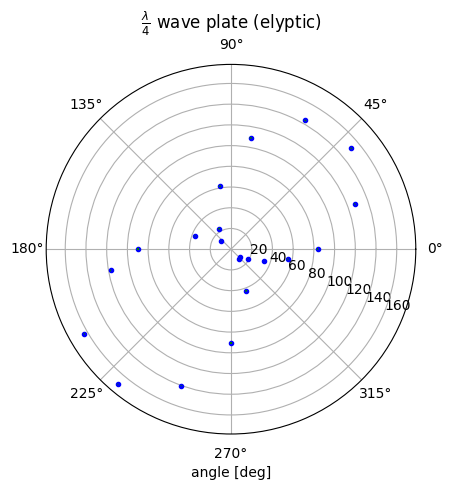

In [105]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# fig, ax = plt.subplots()
plot_data = uplot(clean_errors(df)['angle'].to_numpy(), df['power'].to_numpy(), ax=ax, color='b', fmt='.')

pyplot.xlabel('angle'+' [deg]')
pyplot.title('$\\frac{\\lambda}{4}$ wave plate (elyptic)') 
# pyplot.xscale('log')
plt.grid()
# plot_fit, = ax.plot(X, malus_fit(X, a, b), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])


# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

# ax.set_xticks(range(0, 360, 5))  # Less radial ticks
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_locator(MultipleLocator(20))
ax.grid(True)

plt.savefig('images/quater_elyptic.svg', format='svg')
save_pickle('quater_board_elyptic', df)

## brewster angle

In [46]:
power = []
angle = []
d = read_to_dict('data/brewster')
for k, df_ in d.items():
    df_ = drop(df_, 'p', 3)
    power.append( 10e8 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    angle.append(ufloat(float(k), 1) / 2 * np.pi / 180)
# power = np.array(power)

df = pd.DataFrame({'angle': angle, 'power': power})
df.sort_values(by=['angle'], inplace=True)
    

Error reading file data/brewster/.DS_Store


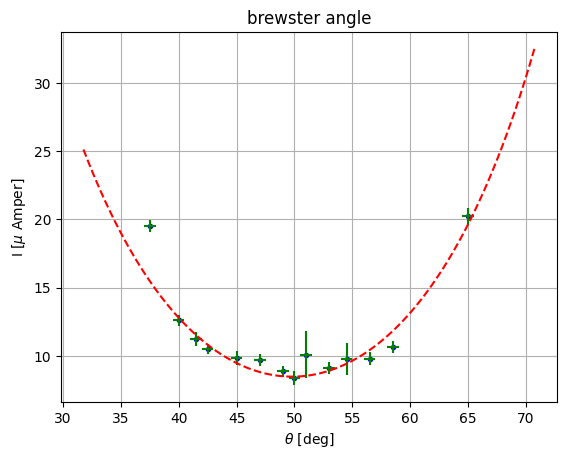

In [63]:
from numpy import tan, sin, cos, arcsin, arccos

a = ufloat(0.869345, 0.0058891)
c = ufloat(-78.201, 6.44443)
n = ufloat(1.24065, 0.00972882)


a = 0.869345
c = -78.201
n = 1.24065

def brewster_fit(x, a, c, n):
    return (tan(x-a + arcsin(sin(x-a)/n)))**2/(tan(x-a - arcsin(sin(x-a)/n)))**2+c

X = genrate_fit_data(df, 'angle', 0.1)

fig, ax = plt.subplots()
plot_data = uplot(df['angle'] * 180 / np.pi , df['power'], ax=ax, color='b', fmt='.')

pyplot.xlabel(r'$\theta$'+' [deg]')
pyplot.ylabel('I [$\mu$ Amper]')
pyplot.title('brewster angle') 
plt.grid()

plot_fit, = ax.plot(X * 180 / np.pi, brewster_fit(X, a, c,n), 'r--')

plt.savefig('images/brewster.svg', format='svg')

In [ ]:
# fig = puplot(df['angle'], df['power'])
# fig.add_trace(
#     go.Scatter(X, y=brewster_fit(X, a, c, n), name="fitting"),
#     secondary_y=False,
# )

# fig = puplot(df['angle'], df['power'])


# fig.add_trace(
#     go.Scatter(
#         x=X,
#         y=brewster_fit(X, a, c, n),
# ))


# (tan(x-a + asin(sin(x-a)/n)))^2/(tan(x-a - asin(sin(x-a)/n)))^2+c

## chirality

In [66]:
temp = ufloat(24,1) # pm 1# ch

power = []
length = []
pard = read_to_dict('data/par')
perd = read_to_dict('data/per')

for k, df_ in pard.items():
    power.append( 10e5 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    length.append(ufloat(float(k), 0.5))

par = pd.DataFrame({'l': length, 'p': power})
par.sort_values(by=['l'], inplace=True) 

power = []
length = []

for k, df_ in perd.items():
    power.append( 10e5 * ufloat(df_['p'].mean(), get_min_max_error(df_, 'p')))
    length.append(ufloat(float(k), 0.5))

per = pd.DataFrame({'l': length, 'p': power})
per.sort_values(by=['l'], inplace=True) 

per = clean_errors(per)
par = clean_errors(par)

tot = pd.DataFrame(
    {'l': np.array(length) / 10, 'theta': 180/np.pi * np.arctan(( per['p'] / par['p'] )**0.5)}
    )
# tot.sort_values(by=['l'], inplace=True) 

In [29]:
from uncertainties.umath import atan 

In [6]:
puplot(par['l'], par['p'])

In [7]:
puplot(per['l'], per['p'])

In [21]:
tot = tot[tot['p'] < 100]

In [53]:
puplot(tot['l'], tot['theta'])

In [37]:
puplot(pard['20.5']['t'],pard['20.5']['p'])

In [22]:
import shutil

os.chdir('/Users/user/Documents/semster_c/courses/lab/polarisation/')
folder = 'data/chirality'
par = 'data/par/'
per = 'data/per/'
csv_files = os.listdir(folder)

for x in csv_files:
    if x.endswith('par.xlsx'):
        shutil.copy(os.path.join(folder, x), os.path.join(par, x[:-8] + '.xlsx'))
    elif x.endswith('per.xlsx'):
        shutil.copy(os.path.join(folder, x), os.path.join(per, x[:-8] + '.xlsx'))
    else:
        print(f'file type not found: {x}')

In [ ]:
for i in sorted(pard.keys(), key=float):
    # i = str(i)
    print(i)
    puplot(pard[i]['t'], pard[i]['p'])

In [77]:
c = 102.8 / 550
a = tot['theta'] / (tot['l'] * c)
tot['alpha'] = a

In [ ]:
puplot(tot['l'], tot['alpha'])

In [ ]:
I0 = 1.7